In [376]:
%%capture
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import rc
from tqdm.notebook import tqdm
from cycler import cycler
tqdm().pandas()

fontsize = 12
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
rc('text', usetex=True)

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path       = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
path_data_files = '/Users/Stefa/Documents/Sentiment Analysis Files/'

extended_model_path = data_path+'Classification/DagoBERT/SCE_Loss_minw_25_lr_5e5_3ep_bs32_wd_1e2_a0_5_b3_NN1_w2v_topics/' 
extended_data_path  = path_data_files+'filtered_news_data_for_transformer/train_validation_data' #data_with_922_constituents/train_validation_data/'

output_path   = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/"
fin_data_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/"    


def load_data(file):
    df = pd.read_csv(file, encoding='utf-8-sig')
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index(['Ticker', 'Date'])
    df = df.rename(columns={'Prediction value': 'prediction_value'})
    return df


In [58]:
# Load Beta values (file reference: Volatility adjusted labels.ipynb)
beta = pd.read_csv(data_path+'beta_moc_df.csv')     
beta.Date = pd.to_datetime(beta.Date)
beta = beta[beta['Date'].dt.year >= 2002]
beta = beta[beta['Date'].dt.year <= 2021]
beta = beta.set_index('Date')
beta = beta.stack().reset_index().rename(columns={'level_1':'Ticker', 0:'beta'}).set_index(['Ticker', 'Date'])
beta.head()

,MLM,TSCO,ALB,QLGC,WAI,AVB,CPRT,AKS,SIND,QTRN,NKTR,LEHMQ,ASND,ESS,GLD,...,NKE,GL,FITB,INGR,PCP,EC,KATE,HBOC,SGAT,BGEN,HD,IGT,CA,MU,sp500_return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01,0.655429,0.578335,0.566464,3.327776,NaN,0.153489,0.883339,0.837372,0.151632,1.148627,1.697717,1.923174,NaN,0.221720,NaN,...,0.674650,0.710893,0.915737,1.202751,0.878511,0.749010,0.859507,NaN,NaN,1.225982,1.369842,0.658808,1.629611,2.031525,1.002070
2002-01-02,0.656779,0.574727,0.569971,3.326380,NaN,0.153193,0.885424,0.839966,0.151845,1.147241,1.701226,1.919786,NaN,0.222207,NaN,...,0.675910,0.709820,0.912948,1.202900,0.877217,0.750210,0.860243,NaN,NaN,1.219427,1.372070,0.663326,1.628102,2.036249,1.002070
2002-01-03,0.657197,0.576047,0.571749,3.325137,NaN,0.153038,0.881972,0.829087,0.151558,1.143306,1.697465,1.921134,NaN,0.222132,NaN,...,0.676556,0.710616,0.914974,1.202062,0.876752,0.750869,0.859485,NaN,NaN,1.220174,1.373595,0.662947,1.628380,2.035041,1.002075
2002-01-04,0.657400,0.582077,0.571954,3.328314,NaN,0.152638,0.879060,0.822436,0.151064,1.144712,1.693036,1.919314,NaN,0.222112,NaN,...,0.675280,0.709668,0.915089,1.203449,0.875484,0.750416,0.858337,NaN,NaN,1.219787,1.372654,0.662674,1.625153,2.039937,1.002075
2002-01-07,0.664725,0.579163,0.569259,3.347773,NaN,0.150586,0.894334,0.835818,0.151948,1.143352,1.706628,1.916722,NaN,0.220121,NaN,...,0.676566,0.702384,0.916710,1.214729,0.886380,0.755313,0.856289,NaN,NaN,1.206258,1.370431,0.655660,1.626313,2.042027,1.002075


In [18]:
z_scores = pd.read_csv(data_path+f'z_values_mo_to_mc_127d_rw_idiosync.csv', encoding='utf-8')      
z_scores.Date = pd.to_datetime(z_scores.Date)                                   
z_scores = z_scores.set_index('Date')
z_scores = z_scores.stack().reset_index().rename(columns={'level_1':'Ticker', 0:'z_score_close'}).set_index(['Ticker', 'Date'])

In [395]:
test_data_pred = load_data(extended_model_path+'train_valid_data_pred_and_abn_returns_mc_to_mo_17_5h_z_val_idiosync_fresh_'+str(2002)+'-'+str(2021)+'.csv')
test_data_pred = test_data_pred.reset_index()
test_data_pred = test_data_pred.reset_index(drop=True).set_index(['Ticker', 'Date'])
print(test_data_pred.shape)
test_data_pred.head(2)

(128464, 32)


,,Timestamp_ET,News,Sentiment,freshness,topic_1,topic_2,topic_3,topic_4,neutral,negative,positive,Prediction,prediction_value,return_t_V,return_t_IV,...,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,z_value_t_III,z_value_t_II,z_value_t_I,z_value_t,z_value_t_1
Ticker,Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DIS,2002-01-07,2002-01-07 16:28:06.983,disney shareholders renew suit over ovitz payo...,0.0,fresh,0.0,0.000000,0.0,0.000000,0.954279,0.018684,0.027037,0,0.008352,NaN,0.001005,...,0.009330,0.005319,-0.002831,0.023241,-0.018726,-0.011713,0.009509,0.003659,0.00425,-0.005700,NaN,NaN,NaN,NaN,NaN
XRX,2002-01-07,2002-01-07 16:40:01.416,text fitch affirms xerox ratings outlook is st...,0.0,fresh,0.0,0.193966,0.0,0.395062,0.901240,0.039803,0.058957,0,0.019154,NaN,-0.002169,...,-0.036548,-0.033012,-0.016464,-0.006209,0.010254,-0.001681,0.001663,-0.009409,-0.00773,-0.012001,NaN,NaN,NaN,NaN,NaN


Naive Predictior:   
Neg. Sentiment -> neg. Return  
Pos. Sentimetn -> pos. Return

In [396]:
barrier = 0.95
y_pred_neg = test_data_pred.loc[test_data_pred.prediction_value <= -barrier, 'return_t'] < 0
y_pred_pos = test_data_pred.loc[test_data_pred.prediction_value >=  barrier, 'return_t'] > 0
print(f"Precision (neg): {y_pred_neg.sum()/y_pred_neg.shape[0]:.4f}")
print(f"Precision (pos): {y_pred_pos.sum()/y_pred_pos.shape[0]:.4f}")

Precision (neg): 0.6689
Precision (pos): 0.6813


In [397]:
test_data_pred = pd.merge(left=test_data_pred, right=z_scores, left_index=True, right_index=True, how='inner')
test_data_pred = pd.merge(left=test_data_pred, right=beta, left_index=True, right_index=True, how='left')
test_data_pred = test_data_pred.reset_index(drop=True)

In [398]:
test_data_pred.head(2)

,Timestamp_ET,News,Sentiment,freshness,topic_1,topic_2,topic_3,topic_4,neutral,negative,positive,Prediction,prediction_value,return_t_V,return_t_IV,...,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,z_value_t_III,z_value_t_II,z_value_t_I,z_value_t,z_value_t_1,z_score_close,beta
0,2002-08-06 08:15:57.471,research alert morgan stanley cuts agilent pri...,0.0,fresh,0.227586,0.370690,0.0,0.0,0.004183,0.989396,0.006421,1,-0.982975,0.001503,0.006325,...,0.008908,0.027768,-0.033208,-0.012164,0.004529,-0.007513,0.003522,0.040413,-0.836509,-1.208543,1.722317,-0.965005,0.420149,-0.279147,1.835187
1,2002-08-19 19:44:33.638,otc halt news pending last otc resumed nyse in...,0.0,stale,0.172414,0.241379,0.0,0.0,0.008202,0.987196,0.004602,1,-0.982594,0.004529,-0.007513,...,0.006365,-0.002130,0.000625,0.014729,-0.019901,0.010569,-0.004850,-0.016199,0.170807,1.802119,-1.153949,-3.686928,0.393027,1.157925,1.789099


In [399]:
features = ['topic_1', 'topic_2', 'prediction_value', 'z_score_close', 'beta']

X_y = test_data_pred[features+['return_t']]
X_y = X_y.dropna()

In [400]:
X_y.head(20)

,topic_1,topic_2,prediction_value,z_score_close,beta,return_t
0,0.227586,0.370690,-0.982975,-0.279147,1.835187,-0.021999
1,0.172414,0.241379,-0.982594,1.157925,1.789099,-0.072505
2,0.231034,0.318966,-0.994031,0.429410,1.787976,-0.072505
3,0.268966,0.301724,-0.972799,0.364563,1.810837,0.014729
4,0.117241,0.400862,0.976122,-0.258869,1.671462,0.092657
5,0.000000,0.349138,-0.995599,0.140705,1.634356,-0.175146
6,0.155172,0.301724,-0.986114,-2.436091,1.628876,-0.175146
7,0.148276,0.245690,-0.995394,-2.436091,1.628876,-0.011256
8,0.351724,0.000000,0.994749,-0.129826,1.637956,0.028444
9,0.000000,0.245690,0.996751,-0.238133,1.625911,0.026876


In [401]:
confidence_levels = [0, 0.5, 1, 1.5, 1.645, 1.96]

X_y.z_score_close = X_y.z_score_close.apply(lambda x: max(np.where(abs(x) > np.array(confidence_levels))[0])*np.sign(x))

In [402]:
X_y

,topic_1,topic_2,prediction_value,z_score_close,beta,return_t
0,0.227586,0.370690,-0.982975,-0.0,1.835187,-0.021999
1,0.172414,0.241379,-0.982594,2.0,1.789099,-0.072505
2,0.231034,0.318966,-0.994031,0.0,1.787976,-0.072505
3,0.268966,0.301724,-0.972799,0.0,1.810837,0.014729
4,0.117241,0.400862,0.976122,-0.0,1.671462,0.092657
...,...,...,...,...,...,...
124537,0.000000,0.000000,0.993053,1.0,1.007733,0.004499
124538,0.000000,0.413793,-0.977418,-1.0,1.007303,0.022752
124539,0.000000,0.000000,-0.001873,-0.0,1.005983,0.000734
124540,0.327586,0.443966,0.986339,0.0,1.017741,-0.003034


In [403]:
X_y = X_y.loc[abs(X_y.prediction_value) >= 0.95]

In [404]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X_y[features], X_y['return_t'], test_size=0.4, random_state=42)

In [406]:
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

X_train.insert(0, 'const', 1.0)  
X_test.insert(0, 'const', 1.0)  


#scaler  = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test  = scaler.transform(X_test)

In [407]:
model = sm.OLS(y_train, X_train).fit()

In [408]:
y_train_pred = model.predict(X_train)

In [409]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               return_t   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     592.3
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        08:10:43   Log-Likelihood:                 45315.
No. Observations:               26394   AIC:                        -9.062e+04
Df Residuals:                   26388   BIC:                        -9.057e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0040      0.001  

**XGBoost**

* https://xgboost.readthedocs.io/en/
* https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [410]:
from xgboost import XGBRegressor

In [411]:
xgboost_model = XGBRegressor(booster='gbtree',
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             n_estimators=800,
                             learning_rate=0.2,          # learning rate (default=0.3)
                             gamma=0,                   
                             max_depth=6,
                             min_child_weight=1,
                             subsample=0.7,
                             colsample_bytree=0.8,
                             use_label_encoder=False,
                             seed=42
                            )        


evaluation = [( X_train, y_train), ( X_test, y_test)]

#xgboost_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgboost_model.fit(X_train, y_train,
                  eval_set=evaluation, 
                  eval_metric="rmse",
                  early_stopping_rounds=10,
                  verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.7, tree_method='exact', use_label_encoder=False,
             validate_parameters=1, ...)

In [412]:
y_train_pred = xgboost_model.predict(X_train)
y_test_pred  = xgboost_model.predict(X_test)

print(f"MSE Train: {mean_squared_error(y_train, y_train_pred)}")
print(f"MSE Test:  {mean_squared_error(y_test, y_test_pred)}")

MSE Train: 0.0016671646228458123
MSE Test:  0.0018105635784089478


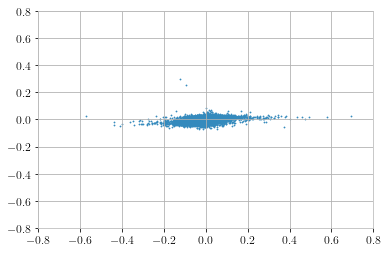

In [413]:
#plt.scatter(y_train, y_train_pred, s=1.5)
plt.scatter(y_test, y_test_pred, s=1.5)
plt.ylim(-0.8, 0.8)
plt.xlim(-0.8, 0.8)
plt.show()

In [426]:
barrier = 0.95
print(f"Precision (neg): {(y_test.loc[y_test_pred < 0] < 0).sum()/(y_test_pred < 0).sum():.4f}")
print(f"Precision (pos): {(y_test.loc[y_test_pred > 0] > 0).sum()/(y_test_pred > 0).sum():.4f}")

Precision (neg): 0.6862
Precision (pos): 0.6688


In [371]:
res_df = pd.DataFrame(data={'y_test':y_test, 'y_test_pred':y_test_pred, 'sentiment':X_test.prediction_value})

In [372]:
res_df.head(20)

,y_test,y_test_pred,sentiment
0,0.005593,0.013652,0.956284
1,-0.003993,0.010389,0.981403
2,0.006731,0.019931,0.990439
3,0.013903,-0.022385,-0.985241
4,-0.073657,-0.016727,-0.987166
5,0.032836,-0.024235,-0.994108
6,0.061504,0.018456,0.987022
7,-0.005404,0.021912,0.993774
8,0.021085,0.016186,0.980519
9,0.061448,0.008395,0.984399
